In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
STATIC_PATH = '/home/elinha/NLP/moducon_data/phase_2'

# Preprocessing Strategy

1. Expand contractions : pycontractions
2. lowercase
3. change numbers to words : inflect
4. Remove Punctuations : '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
5. Remove remained emoji, japanese, chinese, korean words
6. PoS_tagging: from nltk import pos_tag
7. If needed, remove PRP, TO, DT, etc. 
8. Stemming: PorterStemmer
9. Find out average sentence length
10. Wordcloud


## 저장된 파일로 그래프 그리기

In [4]:
import json
# STATIC_PATH = '저장폴더경로'

# JSON 파일에서 불러오기
def load_from_json(file_name):
    with open(os.path.join(STATIC_PATH,file_name), 'r', encoding='utf-8') as f:
        return json.load(f)


# 불러오기
loaded_data = load_from_json('ncfom_for_graph.json')

In [5]:
top_num= 100
target_country = 'china'
modified_sentences_filtered = loaded_data[target_country]['modified_sentences_filtered']
relevant_words = loaded_data[target_country]['relevant_words']

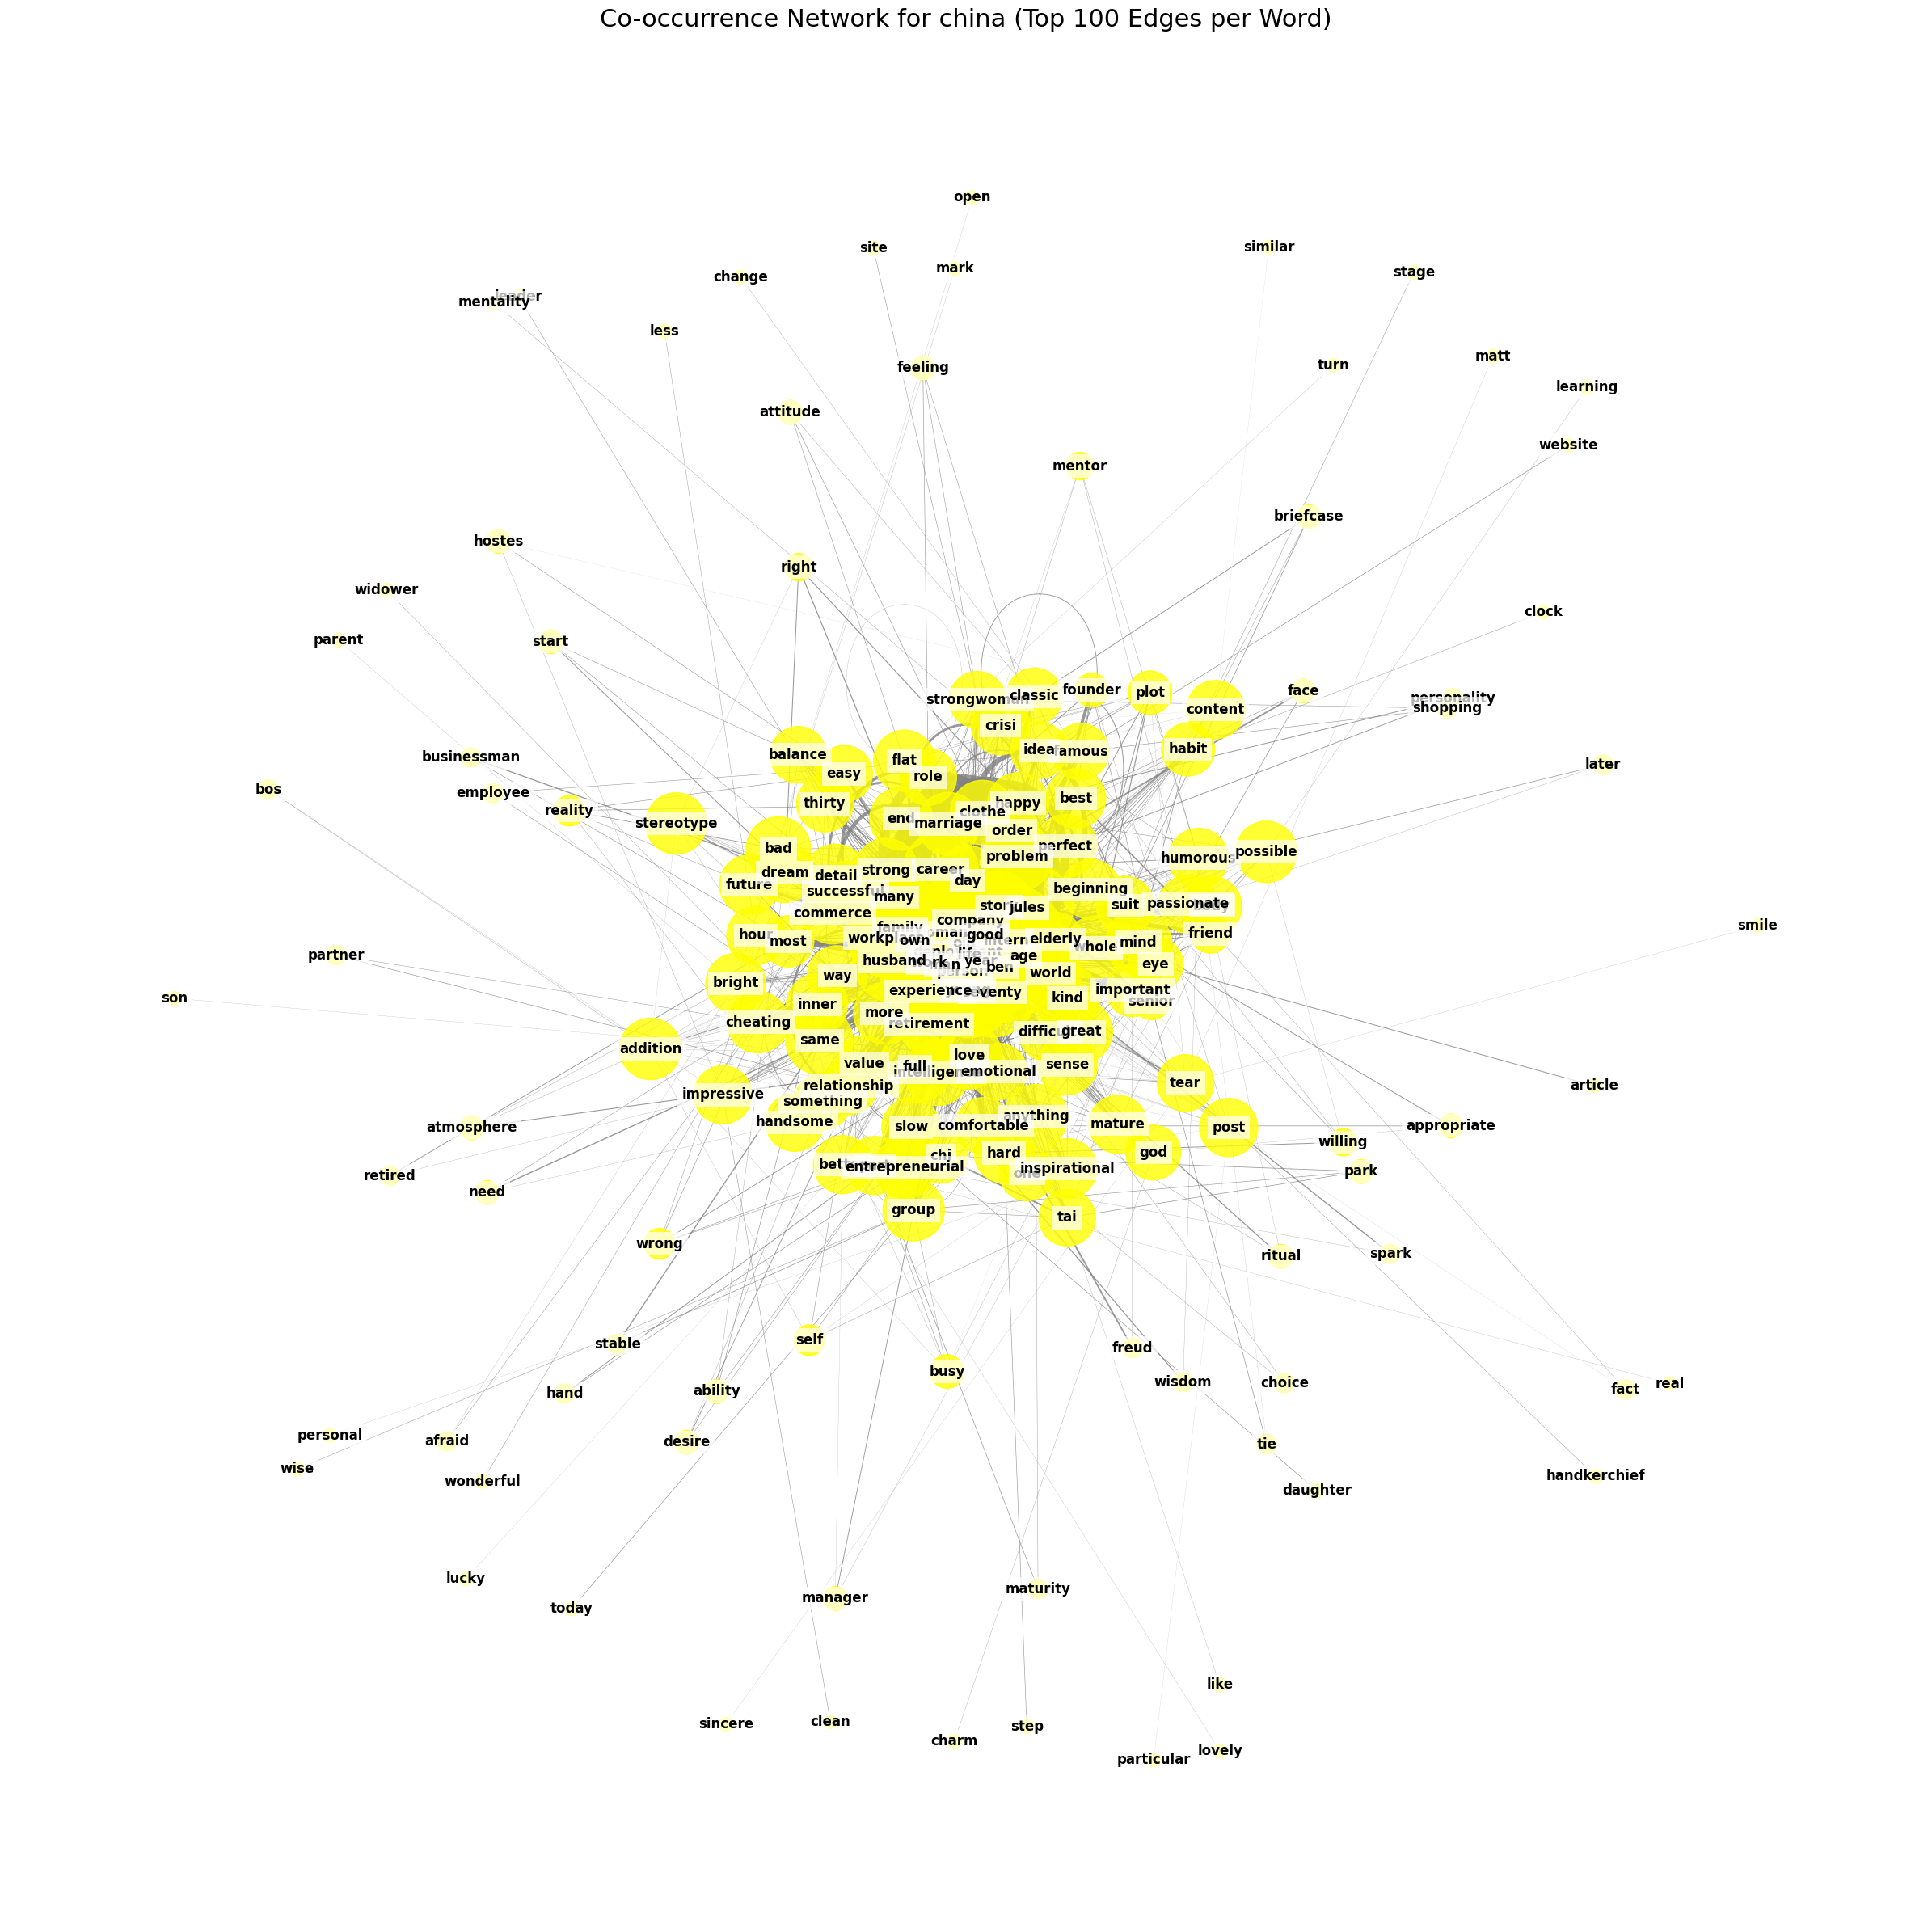

In [7]:
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)

window_size = 20

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)


# relevant_words = set(old_words + young_words)

filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u in relevant_words or v in relevant_words]

H = nx.Graph()
H.add_edges_from(filtered_edges)

H_old_filtered = nx.Graph()

for word in relevant_words[:top_num]:
    edges_for_word = [(u, v, d) for u, v, d in G.edges(data=True) if (u == word or v == word)]
    sorted_edges = sorted(edges_for_word, key=lambda x: x[2]['weight'], reverse=True)[:20]
    H_old_filtered.add_edges_from(sorted_edges)

# Visualization of the subgraph related to old words
plt.figure(figsize=(24,24))

# Adjust the spring layout for better node spacing
pos_old_filtered = nx.spring_layout(H_old_filtered, seed=42, k=1.2)

# Node sizes based on the number of edges (degree) connected to them
node_sizes = [H_old_filtered.degree(node) * 150 for node in H_old_filtered.nodes()]

# Node colors using HEX values (e.g., light blue)
node_colors = [f"#{loaded_data[target_country]['color']}" for _ in H_old_filtered.nodes()]

# Draw edges with varying thickness based on weight
edge_weights = [d['weight'] for (u, v, d) in H_old_filtered.edges(data=True)]
max_weight = max(edge_weights)
normalized_weights = [50 * (w / max_weight) for w in edge_weights]

# Draw nodes, edges, and labels with improved readability
nx.draw_networkx_edges(H_old_filtered, pos_old_filtered, width=normalized_weights, alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(H_old_filtered, pos_old_filtered, node_size=node_sizes, node_color=node_colors, alpha=0.8)

# Add labels with a white background for better visibility
for node, (x, y) in pos_old_filtered.items():
    plt.text(x, y, node, fontsize=12, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f"Co-occurrence Network for {target_country} (Top {top_num} Edges per Word)", fontsize=22)
plt.axis("off")
plt.tight_layout()
plt.show()